# LSTM RNN implementation for energy usage prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import validation_curve, learning_curve

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
energy_data = pd.read_csv('UCI_data.csv', index_col = 0, parse_dates = True)
energy_data.head()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
date,,,,,,,,,,,,,,,,,,,,,
2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,62.166667,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,43.560000,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,46.126667,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,47.700000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,50.745000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


As you can see from the above output, the energy usage has been measured for every 10 minutes. According to requirements,
we have to predict hourly energy usage. Therefore, it is neccessary to resample the given data.

In [3]:
energy_data = energy_data.sort_index()
energy_data = energy_data.resample('H').mean()
energy_data.head()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,19.890000,46.502778,19.200000,44.626528,19.790000,44.897778,18.932778,45.738750,17.166667,55.116667,...,45.446667,6.308333,733.750000,92.000000,6.166667,53.416667,5.050000,26.823044,26.823044,90.000000
2016-01-11 18:00:00,19.897778,45.879028,19.268889,44.438889,19.770000,44.863333,18.908333,46.066667,17.111111,54.977778,...,45.290000,5.941667,734.266667,91.583333,5.416667,40.000000,4.658333,22.324206,22.324206,228.333333
2016-01-11 19:00:00,20.495556,52.805556,19.925556,46.061667,20.052222,47.227361,18.969444,47.815556,17.136111,55.869861,...,45.311389,6.000000,734.791667,89.750000,6.000000,40.000000,4.391667,33.734932,33.734932,198.333333
2016-01-11 20:00:00,20.961111,48.453333,20.251111,45.632639,20.213889,47.268889,19.190833,49.227917,17.615556,74.027778,...,45.118889,6.000000,735.283333,87.583333,6.000000,40.000000,4.016667,25.679642,25.679642,160.000000
2016-01-11 21:00:00,21.311667,45.768333,20.587778,44.961111,20.373333,46.164444,19.425556,47.918889,18.427222,69.037778,...,44.807778,5.833333,735.566667,87.416667,6.000000,40.000000,3.816667,18.826274,18.826274,126.666667


Next, divide the data into independent(X) and dependent(y) variables.

In [4]:
X = energy_data.drop(['TARGET_energy'], axis=1)
y = energy_data['TARGET_energy']

X = np.array(X, dtype = float)
y = np.array(y, dtype = float)

Scaling is required so that no one variable gets higher attention than other.

In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

After splitting the data into train, test and validation sets, I have converted the shape of independent sets into 3-D because LSTM accepts only 3-D inputs.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2105, 1, 26) (2105,) (658, 1, 26) (658,) (527, 1, 26) (527,)


Following tab shows the model building process using hyper parameter tuning for no. of epochs and batch_size using cross-validation.

In [7]:
def build_model():
    model = Sequential()
    model.add(LSTM(100, activation = 'relu', 
                   input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True))
    model.add(LSTM(100, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    adam=Adam(lr= 0.001, epsilon=1e-08, beta_1=0.9, beta_2 = 0.999, decay = 0.0, amsgrad=True)
    model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])
    return model

regressor = KerasRegressor(build_fn = build_model, verbose = 0)
param_grid = dict(batch_size=[100, 300, 500], epochs = [100, 200, 300, 500, 1000])
grid = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = 2)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))
params1 = grid_result.best_params_
print('Best batch size and epochs:')
print(grid_result.best_params_)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Best batch size and epochs:
{'batch_size': 100, 'epochs': 1000}


Now that I have best batch_size and no. of epochs to run, I will do hyper parameter tuning for other LSTM specific parameters.

In [8]:
def build_model1(no_neurons=100, activation='relu', lr = 0.001):
    model = Sequential()
    model.add(Bidirectional(LSTM(no_neurons, activation = activation, 
                   input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True)))
    model.add(Bidirectional(LSTM(no_neurons, activation = activation)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    adam=Adam(lr = lr, epsilon = 1e-08, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0, amsgrad=True)
    model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])
    return model

regressor = KerasRegressor(build_fn = build_model1, verbose = 0)
neurons = [10, 50, 100, 150]
activation = ['relu', 'sigmoid', 'tanh']
lr = [0.001, 0.01, 0.1]

param_grid = dict(no_neurons = neurons,
                  activation = activation,
                  lr = lr,
                  batch_size = [params1.get('batch_size')], 
                  epochs = [params1.get('epochs')]
                 )

grid = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = 2)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))
print(abs(grid_result.best_score_), grid_result.best_params_)

# Store best parameters in a new dictionary
selected_params = grid_result.best_params_

42.345274106567096 {'activation': 'relu', 'batch_size': 100, 'epochs': 1000, 'lr': 0.1, 'no_neurons': 150}


I will use these best parameter list to build final LSTM model.

In [21]:
model = Sequential()
model.add(Bidirectional(LSTM(selected_params.get('no_neurons'), activation = selected_params.get('activation'), 
               input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True)))
model.add(Bidirectional(LSTM(selected_params.get('no_neurons'), activation = selected_params.get('activation'))))
model.add(Dropout(0.2))
model.add(Dense(1))
adam=Adam(lr = selected_params.get('lr'), epsilon = 1e-08, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0, amsgrad=True)
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 80,  verbose = 1, mode = 'min')
callbacks_list = [earlystop]
history = model.fit(X_train, y_train, epochs=selected_params.get('epochs'), 
                    batch_size = selected_params.get('batch_size'), validation_data = (X_val, y_val), 
                    verbose = 0, shuffle = False, callbacks = callbacks_list)

Epoch 00801: early stopping


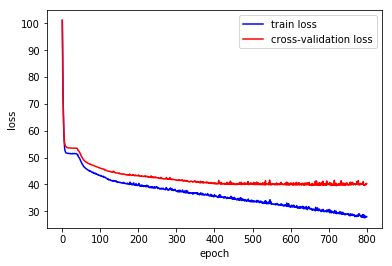

In [23]:
# plotting loss curve to evaluate the performance
plt.plot(history.history['loss'], label='train loss', color='blue')
plt.plot(history.history['val_loss'], label='cross-validation loss', color='red')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [24]:
# Prediction for unseen data
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error: ', mae)

print('Prediction Accuracy for Unseen Data: ',r2_score(y_test, y_pred))
print('Prediction Accuracy over Training Data: ', r2_score(y_train, y_pred_train))

Mean Absolute Error:  33.44200439994217
Prediction Accuracy for Unseen Data:  0.3526932835383594
Prediction Accuracy over Training Data:  0.5292711351716912


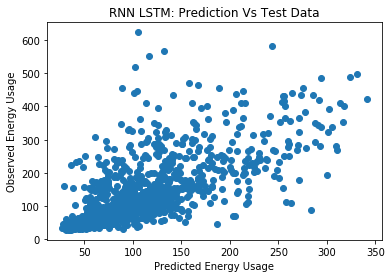

In [25]:
predTest = pd.DataFrame({'prediction': y_pred_test[:, 0], 'observed': y_test})
plt.scatter(predTest['prediction'], predTest['observed'])
plt.title('RNN LSTM: Prediction Vs Test Data')
plt.xlabel('Predicted Energy Usage') 
plt.ylabel('Observed Energy Usage')
plt.show()